In [1]:
!pip install pydicom

In [2]:
!pip install nibabel

In [3]:
import os
import numpy as np
import nibabel as nib
import pydicom
from pydicom.dataset import FileDataset
from datetime import datetime

def create_dicom_slice(slice_data, affine, slice_index, axis, axis_label, output_path):
    
    norm_slice = (slice_data - np.min(slice_data)) / (np.ptp(slice_data) + 1e-5)
    pixel_data = np.uint16(norm_slice * 255)

    file_meta = pydicom.dataset.FileMetaDataset()
    file_meta.MediaStorageSOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
    file_meta.ImplementationClassUID = pydicom.uid.PYDICOM_IMPLEMENTATION_UID

    filename = os.path.join(output_path, f"{axis_label}slice{slice_index:03d}.dcm")
    ds = FileDataset(filename, {}, file_meta=file_meta, preamble=b"\0" * 128)

    ds.PatientName = "Patient1"
    ds.PatientID = "12345"
    ds.StudyDate= "04/10/2006"
    ds.Modality = "MR"
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = file_meta.MediaStorageSOPInstanceUID
    ds.SOPClassUID = file_meta.MediaStorageSOPClassUID

    now = datetime.now()
    ds.ContentDate = now.strftime('%Y%m%d')
    ds.ContentTime = now.strftime('%H%M%S')

    ds.Rows, ds.Columns = slice_data.shape
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 0
    ds.PixelData = pixel_data.tobytes()

    ds.PixelSpacing = [str(abs(affine[0, 0])), str(abs(affine[1, 1]))]
    ds.SliceThickness = str(abs(affine[2, 2]))

    # Image position
    voxel_index = [0, 0, 0]
    voxel_index[axis] = slice_index
    world_position = affine @ [*voxel_index, 1]
    ds.ImagePositionPatient = [str(coord) for coord in world_position[:3]]

    # Image orientation patient 
    orientation = {
        'axial':    ['1', '0', '0', '0', '1', '0'],
        'coronal':  ['1', '0', '0', '0', '0', '1'],
        'sagittal': ['0', '1', '0', '0', '0', '1']
    }
    ds.ImageOrientationPatient = orientation[axis_label]

    ds.save_as(filename)

def convert_nifti_to_dicom_slices(nifti_file, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    nifti_img = nib.load(nifti_file)
    volume_data = nifti_img.get_fdata()
    affine_matrix = nifti_img.affine

    planes = {
        'axial': 2,
        'coronal': 1,
        'sagittal': 0
    }

    for label, axis in planes.items():
        plane_output = os.path.join(output_dir, label)
        os.makedirs(plane_output, exist_ok=True)
        num_slices = volume_data.shape[axis]

        for idx in range(num_slices):
            if axis == 0:
                slice_img = volume_data[idx, :, :]
            elif axis == 1:
                slice_img = volume_data[:, idx, :]
            else:
                slice_img = volume_data[:, :, idx]

            create_dicom_slice(slice_img, affine_matrix, idx, axis, label, plane_output)

        print(f"DICOM slices saved for {label} view at {plane_output}")
nifti_path = "Sample_Data/MRI_data.nii"
output_root = "Sample_Data/MRI_data"
convert_nifti_to_dicom_slices(nifti_path, output_root)

c:\Users\shamb\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydicom\valuerep.py:440: UserWarning: Invalid value for VR DA: '04/10/2006'.
  warn_and_log(msg)
c:\Users\shamb\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydicom\valuerep.py:440: UserWarning: The value length (18) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
c:\Users\shamb\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydicom\valuerep.py:440: UserWarning: The value length (19) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
c:\Users\shamb\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydicom\valuerep.py:440: UserWarning: The value length (17) exceeds the maximum length of 16 al

DICOM slices saved for axial view at Sample_Data/MRI_data\axial
DICOM slices saved for coronal view at Sample_Data/MRI_data\coronal


c:\Users\shamb\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydicom\valuerep.py:440: UserWarning: The value length (22) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)


DICOM slices saved for sagittal view at Sample_Data/MRI_data\sagittal


In [4]:
# Load NIFTI
import nibabel as nib
nii = nib.load("Sample_Data/MRI_data.nii")
data = nii.get_fdata()

import pydicom
ds = pydicom.dcmread('Sample_Data/MRI_data/axial/axialslice000.dcm')
print(ds.PatientName)
print(ds.pixel_array.shape)


Patient1
(256, 362)


In [5]:
import nibabel as nib
import numpy as np
import pydicom

nifti_path = "Sample_Data/MRI_data.nii"
nifti_img = nib.load(nifti_path)
volume_data = nifti_img.get_fdata()
affine_matrix = nifti_img.affine
header = nifti_img.header

print("NIFTI Metadata")
print("Image shape:", volume_data.shape)
print("Data type:", volume_data.dtype)
print("Affine matrix:\n", affine_matrix)
voxel_spacing = np.sqrt(np.sum(affine_matrix[:3, :3] ** 2, axis=0))
print("Voxel spacing (approximate):", voxel_spacing)
print("Header info keys:", list(header.keys()))
print("Example header field (descrip):", header['descrip'].item().decode('utf-8'))

# DICOM metadata 
dicom_path = "Sample_Data/MRI_data/axial/axialslice000.dcm"

ds = pydicom.dcmread(dicom_path)

print("\nDICOM Metadata")
print("Patient Name:", ds.PatientName)
print("Patient ID:", ds.PatientID)
print("Study Date:", getattr(ds, 'StudyDate', 'Not Available'))
print("Modality:", ds.Modality)
print("Pixel Spacing:", getattr(ds, 'PixelSpacing', 'Not Available'))
print("Slice Thickness:", getattr(ds, 'SliceThickness', 'Not Available'))
print("Image Position Patient:", getattr(ds, 'ImagePositionPatient', 'Not Available'))
print("Image Orientation Patient:", getattr(ds, 'ImageOrientationPatient', 'Not Available'))
print("Rows x Columns:", ds.Rows, "x", ds.Columns)


NIFTI Metadata
Image shape: (256, 362, 384)
Data type: float64
Affine matrix:
 [[ 6.29074156e-01 -1.33072212e-02 -3.11387163e-02 -7.36054077e+01]
 [ 1.63442213e-02  6.21981978e-01  5.91654330e-02 -1.00073349e+02]
 [ 2.99664345e-02 -5.98863661e-02  6.21413589e-01 -1.19990189e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Voxel spacing (approximate): [0.62999954 0.62500003 0.62500001]
Header info keys: ['sizeof_hdr', 'data_type', 'db_name', 'extents', 'session_error', 'regular', 'dim_info', 'dim', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'pixdim', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'descrip', 'aux_file', 'qform_code', 'sform_code', 'quatern_b', 'quatern_c', 'quatern_d', 'qoffset_x', 'qoffset_y', 'qoffset_z', 'srow_x', 'srow_y', 'srow_z', 'intent_name', 'magic']
Example header field (descrip): TE=2.1;

In [6]:
import os
import numpy as np
import pydicom

def load_dicom_volume(dicom_dir):
    dicom_files = [pydicom.dcmread(os.path.join(dicom_dir, f)) 
                   for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
    try:
        dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    except AttributeError:
        dicom_files.sort(key=lambda x: int(x.InstanceNumber))

    volume_3d = np.stack([ds.pixel_array for ds in dicom_files], axis=-1)

    return volume_3d, dicom_files

# For axial
dicom_directory = "Sample_Data/MRI_data/axial"  
volume, slices = load_dicom_volume(dicom_directory)

print("Volume shape (H x W x Num_slices):", volume.shape)
print("Pixel spacing:", getattr(slices[0], 'PixelSpacing', 'Unknown'))
print("Slice thickness:", getattr(slices[0], 'SliceThickness', 'Unknown'))


Volume shape (H x W x Num_slices): (256, 362, 384)
Pixel spacing: [0.6290741562843323, 0.6219819784164429]
Slice thickness: 0.6214135885238647


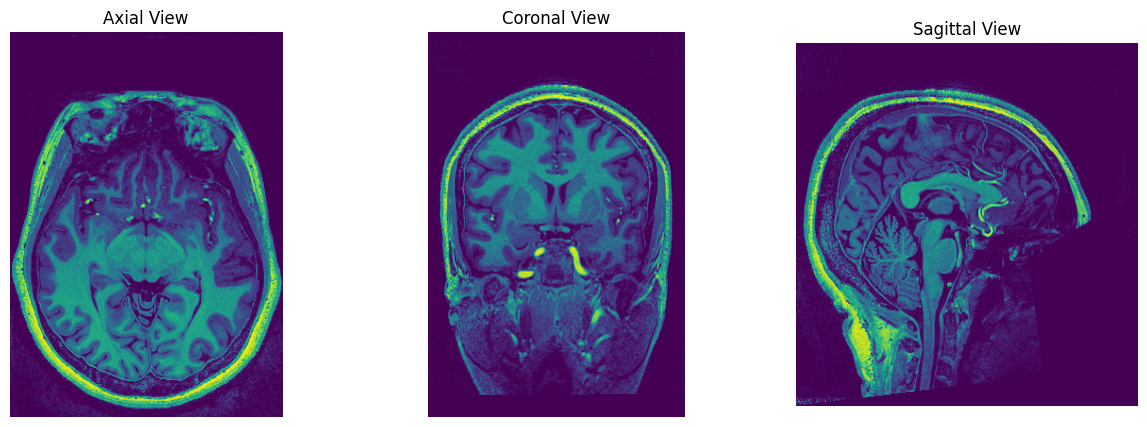

In [7]:
import matplotlib.pyplot as plt

def plot_anatomical_planes(volume):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Axial (z)
    axial_slice = volume[:, :, volume.shape[2] // 2]
    axes[0].imshow(axial_slice.T,  origin='lower')
    axes[0].set_title('Axial View')
    
    # Coronal (y)
    coronal_slice = volume[:, volume.shape[1] // 2, :]
    axes[1].imshow(coronal_slice.T, origin='lower')
    axes[1].set_title('Coronal View')
    
    # Sagittal (x)
    sagittal_slice = volume[volume.shape[0] // 2, :, :]
    axes[2].imshow(sagittal_slice.T, origin='lower')
    axes[2].set_title('Sagittal View')

    for ax in axes:
        ax.axis('off')

    plt.show()

plot_anatomical_planes(volume)


In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

def interactive_slices(volume):
    def view_slices(axial_idx=volume.shape[2]//2, 
                    coronal_idx=volume.shape[1]//2, 
                    sagittal_idx=volume.shape[0]//2):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(volume[:, :, axial_idx].T, origin='lower')
        axes[0].set_title(f'Axial Slice {axial_idx}')
        axes[0].axis('off')

        axes[1].imshow(volume[:, coronal_idx, :].T, origin='lower')
        axes[1].set_title(f'Coronal Slice {coronal_idx}')
        axes[1].axis('off')

        axes[2].imshow(volume[sagittal_idx, :, :].T, origin='lower')
        axes[2].set_title(f'Sagittal Slice {sagittal_idx}')
        axes[2].axis('off')

        plt.show()

    # interactive widget
    ui = widgets.interactive(
        view_slices,
        axial_idx=widgets.IntSlider(min=0, max=volume.shape[2]-1, step=1, value=volume.shape[2]//2, description='Axial'),
        coronal_idx=widgets.IntSlider(min=0, max=volume.shape[1]-1, step=1, value=volume.shape[1]//2, description='Coronal'),
        sagittal_idx=widgets.IntSlider(min=0, max=volume.shape[0]-1, step=1, value=volume.shape[0]//2, description='Sagittal')
    )
    display(ui)
interactive_slices(volume)


interactive(children=(IntSlider(value=192, description='Axial', max=383), IntSlider(value=181, description='Co…

In [9]:
nifti_img = nib.load("Sample_Data/MRI_data.nii")
affine = nifti_img.affine
print(affine)

[[ 6.29074156e-01 -1.33072212e-02 -3.11387163e-02 -7.36054077e+01]
 [ 1.63442213e-02  6.21981978e-01  5.91654330e-02 -1.00073349e+02]
 [ 2.99664345e-02 -5.98863661e-02  6.21413589e-01 -1.19990189e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [10]:
import nibabel as nib
orientation = nib.aff2axcodes(nifti_img.affine)
print("Orientation:", orientation)

Orientation: ('R', 'A', 'S')


In [11]:
import pydicom
ds = pydicom.dcmread("Sample_Data/MRI_data/axial/axialslice000.dcm")

print("Image Position:", ds.ImagePositionPatient)
print("Image Orientation:", ds.ImageOrientationPatient)

Image Position: [-73.60540771484375, -100.07334899902344, -119.99018859863281]
Image Orientation: [1, 0, 0, 0, 1, 0]
